[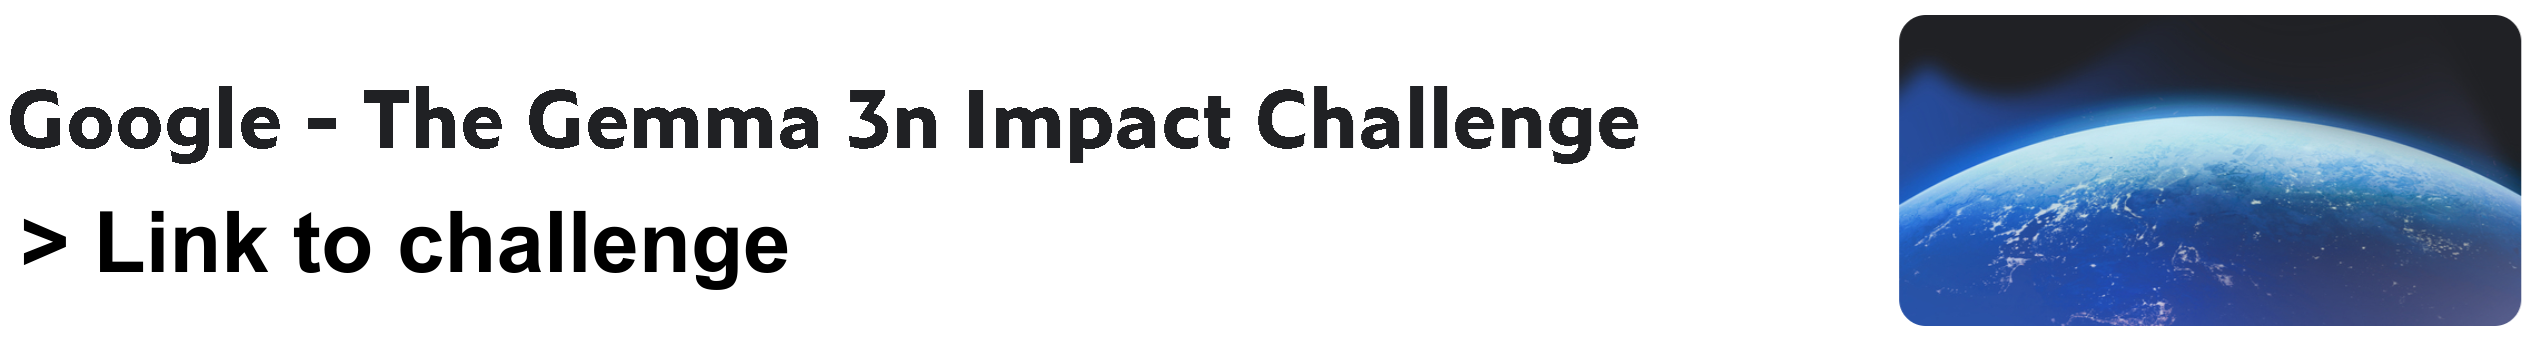](https://www.kaggle.com/competitions/google-gemma-3n-hackathon/overview)

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Kaggle instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).

### Installation

### Unsloth

`FastModel` supports loading nearly any model now! This includes Vision, Text and Audio models!

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [32]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
    # Pretrained models
    "unsloth/gemma-3n-E4B-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-unsloth-bnb-4bit",

    # Other Gemma 3 quants
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E2B-it", # Or "unsloth/gemma-3n-E2B-it"
    dtype = None, # None for auto detection
    #max_seq_length = 40, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.55.0.dev0.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


# Let's finetune Gemma 3N!

You can finetune the vision and text parts for now through selection - the audio part can also be finetuned - we're working to make it selectable as well!

We now add LoRA adapters so we only need to update a small amount of parameters!

In [3]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # Should leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0.05, # Dropout for LoRA layers
    bias = "none",
    random_state = 3407,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep

In [4]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [5]:
from datasets import load_from_disk
dt = load_from_disk("data/enem_train_reason")
#dt = load_from_disk("data/enem_train")
dt_2024 = load_from_disk("data/enem_2024")

We now use `standardize_data_formats` to try converting datasets to the correct format for finetuning purposes!

In [6]:
from unsloth.chat_templates import standardize_data_formats
dataset = standardize_data_formats(dt)
dataset_2024 = standardize_data_formats(dt_2024)

Unsloth: Standardizing formats (num_proc=192): 100%|██████████| 1519/1519 [00:00<00:00, 2186.98 examples/s]
num_proc must be <= 179. Reducing num_proc to 179 for dataset of size 179.


We now have to apply the chat template for `Gemma-3` onto the conversations, and save it to `text`. We remove the `<bos>` token using removeprefix(`'<bos>'`) since we're finetuning. The Processor will add this token before training and the model expects only one.

In [7]:
def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

Map: 100%|██████████| 1519/1519 [00:00<00:00, 8053.52 examples/s]


Let's see how the chat template did! Notice there is no `<bos>` token as the processor tokenizer will be adding one.

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [8]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 1, # Use GA to mimic batch size!
        warmup_steps = 10,
         num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 60,
        learning_rate = 2e-6,
        logging_steps = 10,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2): 100%|██████████| 1519/1519 [00:02<00:00, 693.82 examples/s]


[2025-08-06 20:28:52,433] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2025-08-06 20:28:52,924] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs. This helps increase accuracy of finetunes!

In [9]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=192): 100%|██████████| 1519/1519 [00:00<00:00, 1841.39 examples/s]


Let's verify masking the instruction part is done! Let's print the 100th row again.  Notice how the sample only has a single `<bos>` as expected!

In [10]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

'<bos><start_of_turn>user\n## Técnica modifica proteína do veneno de cascavel e permite criar fármaco que modula a coagulação sanguínea\nO veneno da cascavel pode causar hemorragia com risco de morte a quem é picado pela serpente. No entanto, pesquisadores do Brasil e da Bélgica desenvolveram uma molécula de interesse farmacêutico, a PEG-collineína-1, a partir de uma proteína encontrada no veneno dessa cobra, capaz de modular a coagulação sanguínea. Embora a técnica não seja nova, foi a primeira vez que o método foi usado a partir de uma toxina animal na sua forma recombinante, ou seja, produzida em laboratório por um fungo geneticamente modificado.\nEsse novo medicamento apresenta potencial aplicação para\n\n\nAlternativas:\nA - impedir a formação de trombos, típicos em alguns casos de acidente vascular cerebral.\nB - tratar consequências da anemia profunda, em razão da perda de grande volume de sangue.\nC - evitar a manifestação de urticárias, comumente relacionadas a processos alérg

Now let's print the masked out example - you should see only the answer is present:

In [11]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                 A - impedir a formação de trombos, típicos em alguns casos de acidente vascular cerebral.\n\nRaciocínio: # Explicação: Proteína de veneno de cascavel e sua aplicação farmacêutica\n\nPara resolver esta questão, precisamos analisar as informações fornecidas sobre a PEG-collineína-1 e identificar sua aplicação médica mais provável.\n\n## Análise das informações-chave do texto:\n\n1. A proteína foi desenvolvida a partir do veneno de cascavel\n2. O texto menciona que a molécula é "capaz de modular a coagulação sanguínea"\n3. Foi produzida em laboratório usando um fungo geneticamente modificado\n\n## Conexão com a aplicação médica:\n\nO ponto crucial aqui é entender o que significa "modular a coagulação sanguínea". A coagu

In [12]:
# @title Show current memory stats
import gc
gc.collect()
torch.cuda.empty_cache()
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.179 GB.
10.377 GB of memory reserved.


# Let's train the model!

To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,519 | Num Epochs = 1 | Total steps = 95
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 10,567,680 of 5,450,005,952 (0.19% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,3.444300
20,2.012200
30,2.011100
40,1.894300
50,1.790600
60,1.905000
70,1.763100
80,1.693300
90,1.761000


Unsloth: Will smartly offload gradients to save VRAM!


In [20]:
# @title Show final memory and time stats
gc.collect()
torch.cuda.empty_cache()
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

550.3292 seconds used for training.
9.17 minutes used for training.
Peak reserved memory = 45.713 GB.
Peak reserved memory for training = 35.336 GB.
Peak reserved memory % of max memory = 57.734 %.
Peak reserved memory for training % of max memory = 44.628 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [15]:
path = "models/enem-gemma-3n-E2B-lora-8-v2"
model.save_pretrained(path)  # Local saving
tokenizer.save_pretrained(path)
# model.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving
# tokenizer.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving

['models/enem-gemma-3n-E2B-lora-8-v2/processor_config.json']

In [16]:
hf_path = "institutogaia/enem-gemma-3n-E2B-lora-8-v2"

In [17]:
model.push_to_hub(hf_path) # Online saving
tokenizer.push_to_hub(hf_path) # Online saving

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Saved model to https://huggingface.co/institutogaia/enem-gemma-3n-E2B-lora-8-v2


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


In [18]:
model.save_pretrained_merged("models/enem-gemma-3n-E2B-lora-8-v2-merged", tokenizer)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 3 files from cache to models/enem-gemma-3n-E2B-lora-8-v2-merged.


Unsloth: Merging weights into 16bit: 100%|██████████| 3/3 [00:23<00:00,  7.74s/it]


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now for all models! For now, you can convert easily to `Q8_0, F16 or BF16` precision. `Q4_K_M` for 4bit will come later!

In [ ]:
if True: # Change to True to save to GGUF
    model.save_pretrained_gguf(
        "models/enem-gemma-3n-E2B-lora-8-v2-merged",
        quantization_type = "Q8_0" # For now only Q8_0, BF16, F16 supported
    )

Likewise, if you want to instead push to GGUF to your Hugging Face account, set `if False` to `if True` and add your Hugging Face token and upload location!

In [32]:
if False: # Change to True to upload GGUF
    model.push_to_hub_gguf(
        "gemma-3N-finetune",
        quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
        repo_id = "HF_ACCOUNT/gemma-3N-finetune-gguf",
        token = "hf_...",
    )

In [36]:
from huggingface_hub import upload_file, snapshot_download

In [38]:
upload_file(
	path_or_fileobj = "/app/models/enem-gemma-3n-E2B-lora-8-v1-merged.Q8_0.gguf",
	path_in_repo = "enem-gemma-3n-E2B-lora-8-v1-merged.Q8_0.gguf",
	repo_id = "institutogaia/enem-gemma-3n-E2B-lora-8-v1-merged",
	repo_type = "model",
)

100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


CommitInfo(commit_url='https://huggingface.co/institutogaia/enem-gemma-3n-E2B-lora-8-v1-merged/commit/2c8a18fe9661bf277322a51ec5cd87e550672090', commit_message='Upload enem-gemma-3n-E2B-lora-8-v1-merged.Q8_0.gguf with huggingface_hub', commit_description='', oid='2c8a18fe9661bf277322a51ec5cd87e550672090', pr_url=None, repo_url=RepoUrl('https://huggingface.co/institutogaia/enem-gemma-3n-E2B-lora-8-v1-merged', endpoint='https://huggingface.co', repo_type='model', repo_id='institutogaia/enem-gemma-3n-E2B-lora-8-v1-merged'), pr_revision=None, pr_num=None)

In [31]:
tokenizer

Gemma3nProcessor:
- feature_extractor: Gemma3nAudioFeatureExtractor {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "dither": 0.0,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "Gemma3nAudioFeatureExtractor",
  "feature_size": 128,
  "fft_length": 1024,
  "fft_overdrive": true,
  "frame_length": 512,
  "hop_length": 160,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "SiglipImageProcessorFast",
  "image_seq_length": 256,
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "input_scale_factor": 1.0,
  "max_frequency": 7600.0,
  "mel_floor": 1e-05,
  "min_frequency": 125.0,
  "padding_side": "right",
  "padding_value": 0.0,
  "per_bin_mean": null,
  "per_bin_stddev": null,
  "preemphasis": 0.97,
  "preemphasis_htk_flavor": true,
  "processor_class

Now, use the `gemma-3N-finetune.gguf` file or `gemma-3N-finetune-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
